In [1]:
import torch
import evaluate
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import transformers
from sentence_transformers import  util
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from transformers import GenerationConfig
from transformers import AutoModelForCausalLM
from evaluate.visualization import radar_plot
from nltk.tokenize import sent_tokenize

/opt/conda/envs/domaine/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [29]:
dir_root = "Data/"
log_prefix = "log_train_history_"
max_token = 256 # max token from dataset
min_token = 100 # min token from dataset
type = pd.read_json(f"{dir_root}qaa_test_measured.json", orient="records")["input"].values[0]

In [20]:
def calc_cossin(ref, pred, st):
    sentences_ref = sent_tokenize(ref)
    encode_ref = st.encode(sentences_ref)
    
    sentences_pred = sent_tokenize(pred)
    encode_pred = st.encode(sentences_pred)
       
    cosine_scores = util.cos_sim(encode_pred, encode_ref).numpy()
    
    return sum([item.max() for item in cosine_scores]) / len(cosine_scores)

In [21]:
def get_best_model(prefix, metric, data):
    columns = [prefix + str(round(treshold,1)) + metric for treshold in np.arange(1.0, -0.1, -0.1)]
    describe = data[columns].describe().T
    val = describe.max()["mean"]
    name = describe[describe["mean"] == val].index[0]

    return name, val

In [23]:
def measure(col, samples, out):
    cossins = []
    rouge1 = []
    rouge2 = []
    rougeL = []
    rougeLsum = []
    meteors = []
    bleus = []
    bleu_precisions_n1 = []
    bleu_precisions_n2 = []
    bleu_precisions_n3 = []
    bleu_precisions_n4 = []
    bleu_brevity_penalty = []
    bleu_length_ratio = []
    bleu_translation_length = []
    bleu_reference_length = []
    
    rouge = evaluate.load('rouge')
    meteor = evaluate.load('meteor')
    bleu = evaluate.load("bleu")
    st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    for i in tqdm(range(len(samples))):
        # Cosine sim
        try:
            cossins.append(calc_cossin(samples["output"].values[i], test_topic[col].values[i], st))
        except:
            cossins.append(0.0)
            
        # rouge
        r_rouge = rouge.compute(
            predictions=[samples[col].values[i]],
            references=[samples["output"].values[i]]
        )
        rouge1.append(r_rouge["rouge1"])
        rouge2.append(r_rouge["rouge2"])
        rougeL.append(r_rouge["rougeL"])
        rougeLsum.append(r_rouge["rougeLsum"])

        # meteor
        r_meteor = meteor.compute(predictions=[samples[col].values[i]], references=[samples["output"].values[i]])
        meteors.append(r_meteor["meteor"])

        # bleu
        try:
            r_bleu = bleu.compute(predictions=[samples[col].values[i]], references=[samples["output"].values[i]])
            bleus.append(r_bleu["bleu"])
            bleu_precisions_n1.append(r_bleu["precisions"][0])
            bleu_precisions_n2.append(r_bleu["precisions"][1])
            bleu_precisions_n3.append(r_bleu["precisions"][2])
            bleu_precisions_n4.append(r_bleu["precisions"][3])
            bleu_brevity_penalty.append(r_bleu["brevity_penalty"])
            bleu_length_ratio.append(r_bleu["length_ratio"])
            bleu_translation_length.append(r_bleu["translation_length"])
            bleu_reference_length.append(r_bleu["reference_length"])
        except:
            bleus.append(0.0)
            bleu_precisions_n1.append(0.0)
            bleu_precisions_n2.append(0.0)
            bleu_precisions_n3.append(0.0)
            bleu_precisions_n4.append(0.0)
            bleu_brevity_penalty.append(0.0)
            bleu_length_ratio.append(0.0)
            bleu_translation_length.append(0.0)
            bleu_reference_length.append(0.0)

    samples[f"{col}_cs"] = cossins
    samples[f"{col}_rouge1"] = rouge1
    samples[f"{col}_rouge2"] = rouge2
    samples[f"{col}_rougeL"] = rougeL
    samples[f"{col}_rougeLsum"] = rougeLsum
    samples[f"{col}_meteor"] = meteors
    samples[f"{col}_bleu"] = bleus
    samples[f"{col}_bleu_precisions_n1"] = bleu_precisions_n1
    samples[f"{col}_bleu_precisions_n2"] = bleu_precisions_n2
    samples[f"{col}_bleu_precisions_n3"] = bleu_precisions_n3
    samples[f"{col}_bleu_precisions_n4"] = bleu_precisions_n4
    samples[f"{col}_bleu_brevity_penalty"] = bleu_brevity_penalty
    samples[f"{col}_bleu_length_ratio"] = bleu_length_ratio
    samples[f"{col}_bleu_translation_length"] = bleu_translation_length
    samples[f"{col}_bleu_reference_length"] = bleu_reference_length

    samples.to_json(out)
    samples.head()

### Calc Measures

In [30]:
# test_topic = pd.read_json(f"{dir_root}test_topic_gen.json", orient="records")
test_topic = pd.read_json(f"{dir_root}qaa_test_measured.json", orient="records")

In [26]:
measure("gptj_fn", test_topic, f"{dir_root}/qaa_test_measured.json")
measure("opt_fn", test_topic, f"{dir_root}/qaa_test_measured.json")
measure("llama_fn", test_topic, f"{dir_root}/qaa_test_measured.json")
measure("llama2_fn", test_topic, f"{dir_root}/qaa_test_measured.json")
measure("llama2_base", test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2c_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2c_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2_fn_rag_s_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

rags = ["llama2_fn_rag_q_" + str(round(treshold,1)) for treshold in np.arange(1.0, -0.1, -0.1)]
for r in rags:
    measure(r, test_topic, f"{dir_root}/qaa_test_measured.json")

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/opt/conda/envs/domaine/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100% 300/300 [00:52<00:00,  5.69it/s]
/tmp/ipykernel_554/2184168768.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [ ]:
test_topic.to_json(f"{dir_root}/qaa_test_measured.json")
test_topic.head()

### Evaulate

In [33]:
test_topic = pd.read_json(f"{dir_root}qaa_test_measured.json", orient="records")

In [34]:
columns = ["gptj_fn_rougeLsum", "opt_fn_rougeLsum", "llama_fn_rougeLsum", "llama2_fn_rougeLsum", "llama2_base_rougeLsum"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_rougeLsum" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_rougeLsum,300.0,0.209079,0.114522,0.046512,0.139289,0.174403,0.226798,0.606635
opt_fn_rougeLsum,300.0,0.208280,0.116646,0.036697,0.134256,0.173783,0.237548,0.703863
llama_fn_rougeLsum,300.0,0.240715,0.135834,0.033149,0.150678,0.199323,0.271532,0.721088
llama2_fn_rougeLsum,300.0,0.251473,0.120498,0.000000,0.171811,0.222470,0.293950,0.718310
llama2_base_rougeLsum,300.0,0.114306,0.041057,0.000000,0.090827,0.112034,0.135258,0.262774
llama2_rag_q_1.0_rougeLsum,300.0,0.268787,0.136550,0.051948,0.165115,0.234040,0.340530,0.781609
llama2_rag_q_0.9_rougeLsum,300.0,0.328494,0.144833,0.059701,0.218338,0.321856,0.413793,0.834951
llama2_rag_q_0.8_rougeLsum,300.0,0.308433,0.146622,0.054054,0.201258,0.289315,0.393594,0.808290
llama2_rag_q_0.7_rougeLsum,300.0,0.293126,0.147039,0.076271,0.195055,0.263447,0.356406,0.892704
llama2_rag_q_0.6_rougeLsum,300.0,0.262870,0.115944,0.017167,0.178264,0.246144,0.317251,0.753731


In [35]:
columns = ["gptj_fn_meteor", "opt_fn_meteor", "llama_fn_meteor", "llama2_fn_meteor", "llama2_base_meteor"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_meteor" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_meteor,300.0,0.311084,0.146251,0.033343,0.218593,0.278799,0.351154,0.779473
opt_fn_meteor,300.0,0.303043,0.144315,0.025467,0.207821,0.279020,0.342514,0.778984
llama_fn_meteor,300.0,0.321983,0.158977,0.050424,0.212772,0.287640,0.382019,0.816689
llama2_fn_meteor,300.0,0.325760,0.163304,0.004105,0.219999,0.292907,0.382389,0.801521
llama2_base_meteor,300.0,0.161005,0.067121,0.013656,0.114199,0.158643,0.200358,0.358464
llama2_rag_q_1.0_meteor,300.0,0.315543,0.155023,0.043628,0.199657,0.286213,0.394961,0.792612
llama2_rag_q_0.9_meteor,300.0,0.375608,0.168903,0.047043,0.242941,0.365228,0.486018,0.846859
llama2_rag_q_0.8_meteor,300.0,0.349598,0.172276,0.043172,0.215135,0.328527,0.455708,0.885115
llama2_rag_q_0.7_meteor,300.0,0.332900,0.171659,0.046920,0.216515,0.295095,0.423878,0.975120
llama2_rag_q_0.6_meteor,300.0,0.299444,0.147847,0.020964,0.197138,0.270571,0.369015,0.885645


In [36]:
columns = ["gptj_fn_bleu", "opt_fn_bleu", "llama_fn_bleu", "llama2_fn_bleu", "llama2_base_bleu"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_bleu" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_bleu,300.0,0.077690,0.097515,0.0,0.000000,0.044554,0.099084,0.400560
opt_fn_bleu,300.0,0.078849,0.102877,0.0,0.000000,0.044179,0.099081,0.493985
llama_fn_bleu,300.0,0.100002,0.121655,0.0,0.000012,0.059860,0.125221,0.507171
llama2_fn_bleu,300.0,0.104193,0.111173,0.0,0.028115,0.065761,0.140445,0.603195
llama2_base_bleu,300.0,0.003549,0.011356,0.0,0.000000,0.000000,0.000000,0.072542
llama2_rag_q_1.0_bleu,300.0,0.085472,0.107173,0.0,0.000000,0.053112,0.122117,0.620256
llama2_rag_q_0.9_bleu,300.0,0.136948,0.115495,0.0,0.047795,0.115457,0.206008,0.559101
llama2_rag_q_0.8_bleu,300.0,0.129074,0.121690,0.0,0.034827,0.105240,0.189681,0.626512
llama2_rag_q_0.7_bleu,300.0,0.116428,0.135636,0.0,0.023643,0.077573,0.156538,0.801645
llama2_rag_q_0.6_bleu,300.0,0.093123,0.100392,0.0,0.017192,0.064920,0.130996,0.676354


In [37]:
columns = ["gptj_fn_cs", "opt_fn_cs", "llama_fn_cs", "llama2_fn_cs", "llama2_base_cs"]
columns += ["llama2_rag_q_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2_rag_s_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_q_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
columns += ["llama2c_rag_s_" + str(round(treshold,1)) + "_cs" for treshold in np.arange(1.0, -0.1, -0.1)]
test_topic[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
gptj_fn_cs,300.0,0.523841,0.147282,0.146335,0.424877,0.510935,0.600310,0.956295
opt_fn_cs,300.0,0.526210,0.137747,0.196340,0.433391,0.518224,0.598695,0.952902
llama_fn_cs,300.0,0.569951,0.145731,0.248558,0.467949,0.558037,0.641295,0.950432
llama2_fn_cs,300.0,0.577326,0.138446,0.105508,0.491437,0.573913,0.656669,0.963924
llama2_base_cs,300.0,0.443179,0.136376,0.055070,0.347546,0.442011,0.535094,0.815490
llama2_rag_q_1.0_cs,300.0,0.554525,0.177985,0.111240,0.430174,0.547962,0.681499,0.911901
llama2_rag_q_0.9_cs,300.0,0.601557,0.190497,0.111473,0.466810,0.618986,0.763659,0.938218
llama2_rag_q_0.8_cs,300.0,0.592591,0.188026,0.118311,0.460031,0.591206,0.731675,0.944959
llama2_rag_q_0.7_cs,300.0,0.602602,0.167699,0.114680,0.492355,0.627762,0.709834,0.949780
llama2_rag_q_0.6_cs,300.0,0.583611,0.166081,0.155155,0.463454,0.588207,0.715538,0.939948


In [38]:
print("llama2_rag")
print(get_best_model("llama2_rag_q_", "_meteor", test_topic))
print(get_best_model("llama2_rag_q_", "_bleu", test_topic))
print(get_best_model("llama2_rag_q_", "_rougeLsum", test_topic))
print(get_best_model("llama2_rag_q_", "_cs", test_topic))

print("llama2c_rag")
print(get_best_model("llama2c_rag_q_", "_meteor", test_topic))
print(get_best_model("llama2c_rag_q_", "_bleu", test_topic))
print(get_best_model("llama2c_rag_q_", "_rougeLsum", test_topic))
print(get_best_model("llama2c_rag_q_", "_cs", test_topic))

print("llama2_rag_s")
print(get_best_model("llama2_rag_s_", "_meteor", test_topic))
print(get_best_model("llama2_rag_s_", "_bleu", test_topic))
print(get_best_model("llama2_rag_s_", "_rougeLsum", test_topic))
print(get_best_model("llama2_rag_s_", "_cs", test_topic))

print("llama2c_rag_s")
print(get_best_model("llama2c_rag_s_", "_meteor", test_topic))
print(get_best_model("llama2c_rag_s_", "_bleu", test_topic))
print(get_best_model("llama2c_rag_s_", "_rougeLsum", test_topic))
print(get_best_model("llama2c_rag_s_", "_cs", test_topic))

llama2_rag
('llama2_rag_q_0.9_meteor', np.float64(0.3756080200816667))
('llama2_rag_q_0.9_bleu', np.float64(0.136947948249))
('llama2_rag_q_0.9_rougeLsum', np.float64(0.3284938809676667))
('llama2_rag_q_0.7_cs', np.float64(0.6026019449536667))
llama2c_rag
('llama2c_rag_q_1.0_meteor', np.float64(0.2747437034226667))
('llama2c_rag_q_1.0_bleu', np.float64(0.07090526922566666))
('llama2c_rag_q_1.0_rougeLsum', np.float64(0.214402806852))
('llama2c_rag_q_1.0_cs', np.float64(0.475061848485))
llama2_rag_s
('llama2_rag_s_0.6_meteor', np.float64(0.25665497919866664))
('llama2_rag_s_0.6_bleu', np.float64(0.05925289887333334))
('llama2_rag_s_0.6_rougeLsum', np.float64(0.21839884454699998))
('llama2_rag_s_0.6_cs', np.float64(0.5419003943613334))
llama2c_rag_s
('llama2c_rag_s_1.0_meteor', np.float64(0.33344807897900003))
('llama2c_rag_s_1.0_bleu', np.float64(0.11694207358566665))
('llama2c_rag_s_1.0_rougeLsum', np.float64(0.26921459993566665))
('llama2c_rag_s_0.9_cs', np.float64(0.5196246705959999))

<Axes: >

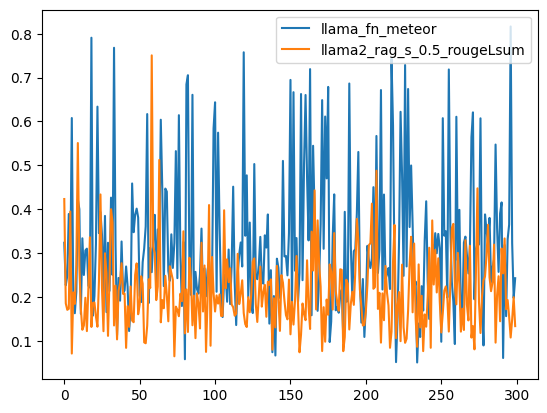

In [39]:
test_topic[["llama_fn_meteor", "llama2_rag_s_0.5_rougeLsum"]].plot()

<Axes: >

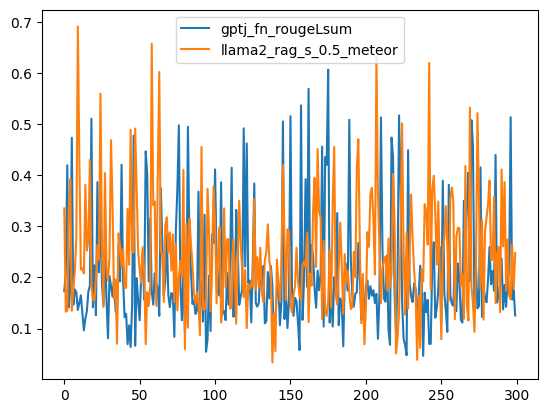

In [40]:
test_topic[["gptj_fn_rougeLsum", "llama2_rag_s_0.5_meteor"]].plot()

<Axes: >

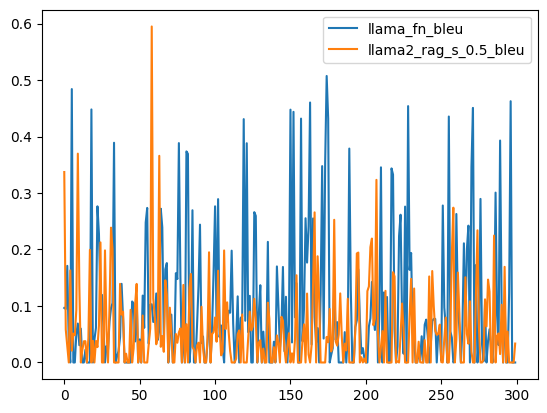

In [41]:
test_topic[["llama_fn_bleu", "llama2_rag_s_0.5_bleu"]].plot()

<Axes: >

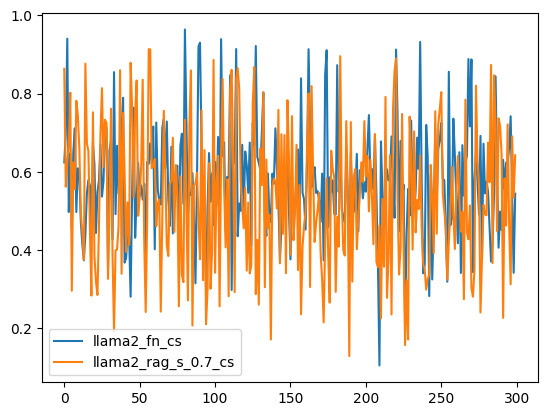

In [42]:
test_topic[["llama2_fn_cs", "llama2_rag_s_0.7_cs"]].plot()

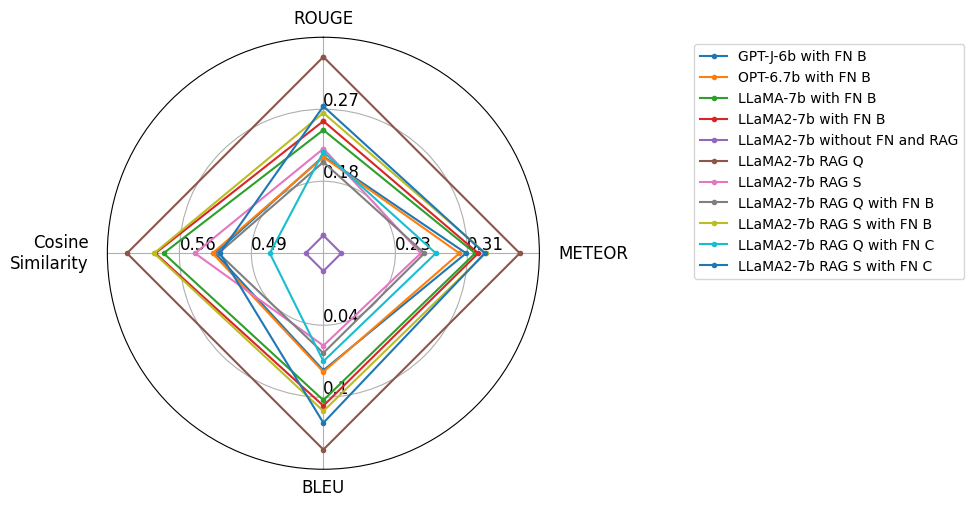

In [43]:
data = [
   {
       "ROUGE": test_topic["gptj_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["gptj_fn_meteor"].values.mean(), 
       "BLEU": test_topic["gptj_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["gptj_fn_cs"].values.mean()
   },
   {
       "ROUGE": test_topic["opt_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["opt_fn_meteor"].values.mean(), 
       "BLEU": test_topic["opt_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["opt_fn_cs"].values.mean()
   },
   {
       "ROUGE": test_topic["llama_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama_fn_meteor"].values.mean(), 
       "BLEU": test_topic["llama_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama_fn_cs"].values.mean()
   }, 
   {
       "ROUGE": test_topic["llama2_fn_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama2_fn_meteor"].values.mean(), 
       "BLEU": test_topic["llama2_fn_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama2_fn_cs"].values.mean(),
   },
   {
       "ROUGE": test_topic["llama2_base_rougeLsum"].values.mean(), 
       "METEOR": test_topic["llama2_base_meteor"].values.mean(), 
       "BLEU": test_topic["llama2_base_bleu"].values.mean(),
       "Cosine Similarity": test_topic["llama2_base_cs"].values.mean()
   },
   {
       "ROUGE": get_best_model("llama2_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_rag_s_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_fn_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_fn_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_fn_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_fn_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2_fn_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2_fn_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2_fn_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2_fn_rag_s_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2c_rag_q_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2c_rag_q_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2c_rag_q_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2c_rag_q_", "_cs", test_topic)[1]
   },
   {
       "ROUGE": get_best_model("llama2c_rag_s_", "_rougeLsum", test_topic)[1], 
       "METEOR": get_best_model("llama2c_rag_s_", "_meteor", test_topic)[1], 
       "BLEU": get_best_model("llama2c_rag_s_", "_bleu", test_topic)[1],
       "Cosine Similarity": get_best_model("llama2c_rag_s_", "_cs", test_topic)[1]
   }
]

model_names = [
    "GPT-J-6b with FN B", "OPT-6.7b with FN B", "LLaMA-7b with FN B", "LLaMA2-7b with FN B",
    "LLaMA2-7b without FN and RAG", 
    "LLaMA2-7b RAG Q", "LLaMA2-7b RAG S",
    "LLaMA2-7b RAG Q with FN B", "LLaMA2-7b RAG S with FN B",
    "LLaMA2-7b RAG Q with FN C", "LLaMA2-7b RAG S with FN C"
]
plot = radar_plot(data=data, model_names=model_names)
plot.show()

## Fine-Tune validation results

In [45]:
val_gptj = pd.read_csv(f"{dir_root}{log_prefix}gptj-6b-v20240926.csv")
val_gptj_c = pd.read_csv(f"{dir_root}{log_prefix}gptj-6b-context-v20240926.csv")
val_llama2_c = pd.read_csv(f"{dir_root}{log_prefix}llama-2-7b-hf-context-v20240927.csv")
val_llama2 = pd.read_csv(f"{dir_root}{log_prefix}llama-2-7b-hf-v20241001.csv")
val_llama_c = pd.read_csv(f"{dir_root}{log_prefix}llama-7b-context-v20240927.csv")
val_llama = pd.read_csv(f"{dir_root}{log_prefix}llama-7b-v20240927.csv")
val_opt_c = pd.read_csv(f"{dir_root}{log_prefix}opt-6.7b-context-v20240927.csv")
val_opt = pd.read_csv(f"{dir_root}{log_prefix}opt-6.7b-v20240926.csv")

validation = pd.DataFrame({
    "gptj" : val_gptj["eval_loss"].dropna().values,
    "gptj_c" : val_gptj_c["eval_loss"].dropna().values,
    "opt" : val_opt["eval_loss"].dropna().values,
    "opt_c" : val_opt_c["eval_loss"].dropna().values,
    "lama" : val_llama["eval_loss"].dropna().values,
    "lama_c" : val_llama_c["eval_loss"].dropna().values,    
    "llama2" : val_llama2["eval_loss"].dropna().values,
    "llama2_c" : val_llama2_c["eval_loss"].dropna().values
})
#validation.index = val_gptj["eval_loss"].dropna().index
validation.to_csv(f"{dir_root}/validation_result.csv")
validation

,gptj,gptj_c,opt,opt_c,lama,lama_c,llama2,llama2_c
0,1.026613,0.759829,1.180150,0.850359,1.032789,0.589571,0.820101,0.608959
1,0.948013,0.705200,1.002593,0.713798,0.802833,0.551165,0.782055,0.563524
2,1.142371,0.819730,1.024832,0.745095,0.852340,0.632585,0.930519,0.640563
3,1.300829,0.891124,1.096023,0.784782,1.060206,0.696070,1.061301,0.715862
4,1.385511,0.940310,1.191012,0.839424,1.175565,0.759167,1.182239,0.776762


In [46]:
def fc(value, bold=False, pad=0):
    value = str(value)
    if pad > 0:
        pad += 2
        value = (value + ("0"*pad))[:pad+1]
        
    if bold:
        return "\multicolumn{1}{c}{\\textbf{" + value+ "}}"
    else:
        return "\multicolumn{1}{c}{" + value + "}"
    
for i in range(len(validation)):
    out = fc(str(i+1), True)  + " & " + \
    fc(str(round(validation["gptj"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["opt"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["lama"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["llama2"].values[i],6)),pad=6) + " & " + \
    fc(str(round(validation["llama2_c"].values[i],6)),pad=6) + " \\\\ "
    print(out)

\multicolumn{1}{c}{\textbf{1}} & \multicolumn{1}{c}{1.0266130} & \multicolumn{1}{c}{1.1801500} & \multicolumn{1}{c}{1.0327890} & \multicolumn{1}{c}{0.8201010} & \multicolumn{1}{c}{0.6089590} \\ 
\multicolumn{1}{c}{\textbf{2}} & \multicolumn{1}{c}{0.9480130} & \multicolumn{1}{c}{1.0025930} & \multicolumn{1}{c}{0.8028330} & \multicolumn{1}{c}{0.7820550} & \multicolumn{1}{c}{0.5635240} \\ 
\multicolumn{1}{c}{\textbf{3}} & \multicolumn{1}{c}{1.1423710} & \multicolumn{1}{c}{1.0248320} & \multicolumn{1}{c}{0.8523400} & \multicolumn{1}{c}{0.9305190} & \multicolumn{1}{c}{0.6405630} \\ 
\multicolumn{1}{c}{\textbf{4}} & \multicolumn{1}{c}{1.3008290} & \multicolumn{1}{c}{1.0960230} & \multicolumn{1}{c}{1.0602060} & \multicolumn{1}{c}{1.0613010} & \multicolumn{1}{c}{0.7158620} \\ 
\multicolumn{1}{c}{\textbf{5}} & \multicolumn{1}{c}{1.3855110} & \multicolumn{1}{c}{1.1910120} & \multicolumn{1}{c}{1.1755650} & \multicolumn{1}{c}{1.1822390} & \multicolumn{1}{c}{0.7767620} \\ 


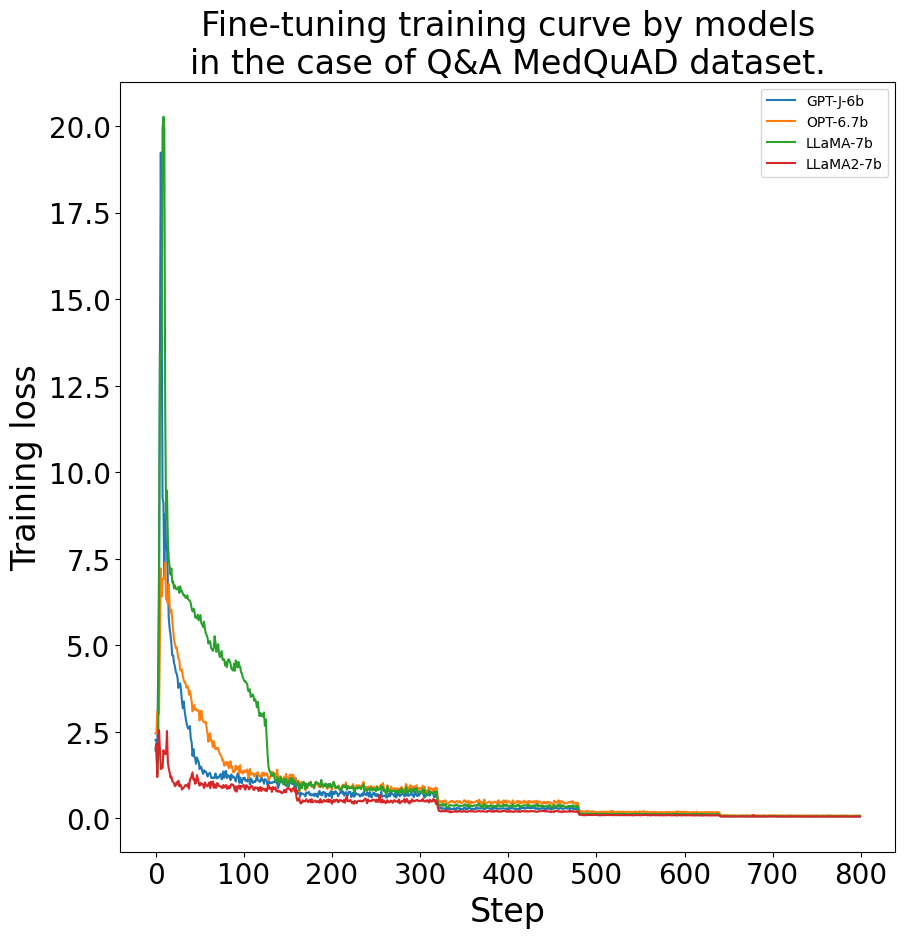

In [51]:
train_models = pd.DataFrame({"GPT-J-6b" : val_gptj[["loss"]].dropna()["loss"].values,
                             "OPT-6.7b" : val_opt[["loss"]].dropna()["loss"].values,
                             "LLaMA-7b" : val_llama[["loss"]].dropna()["loss"].values,
                             "LLaMA2-7b" : val_llama2[["loss"]].dropna()["loss"].values})

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Step', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning training curve by models\nin the case of Q&A MedQuAD dataset.", fontsize=24)
plt.savefig('../images/fn_training_curve_medquad.png')
plt.show()

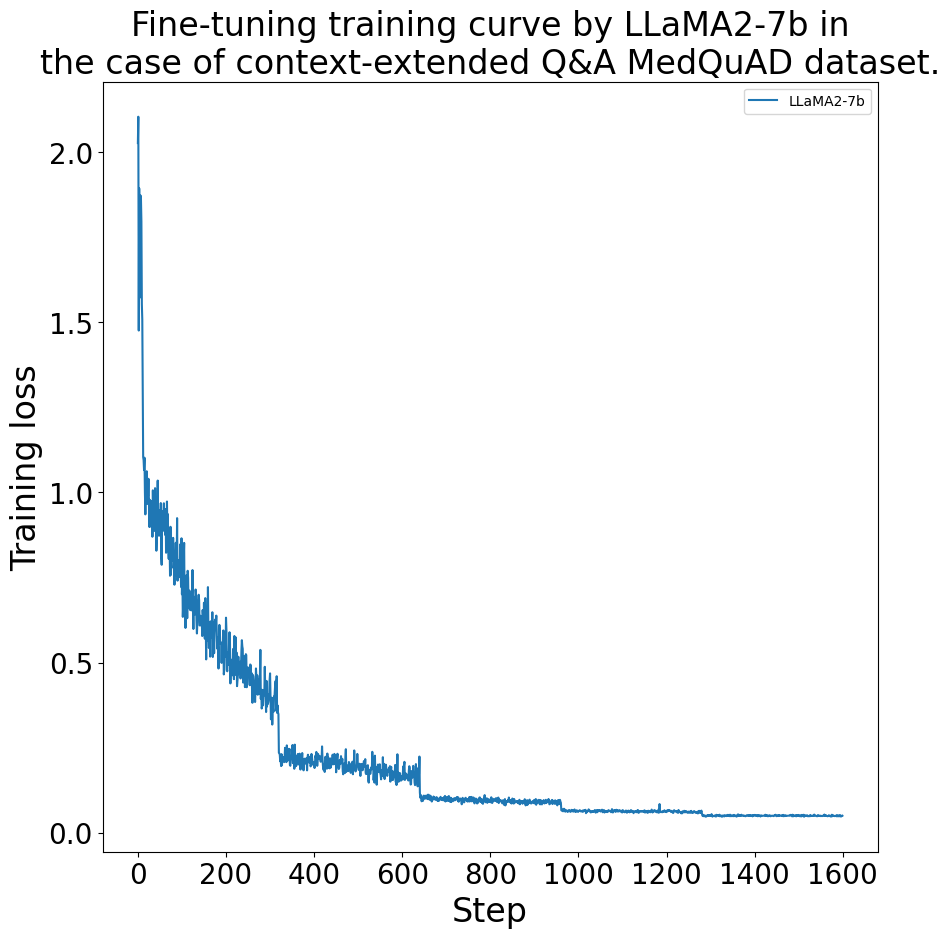

In [52]:
train_models = pd.DataFrame({"LLaMA2-7b" : val_llama2_c[["loss"]].dropna()["loss"].values})

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Step', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning training curve by LLaMA2-7b in\nthe case of context-extended Q&A MedQuAD dataset.", fontsize=24)
plt.savefig('../images/fn_training_curve_context_extended_medquad.png')
plt.show()

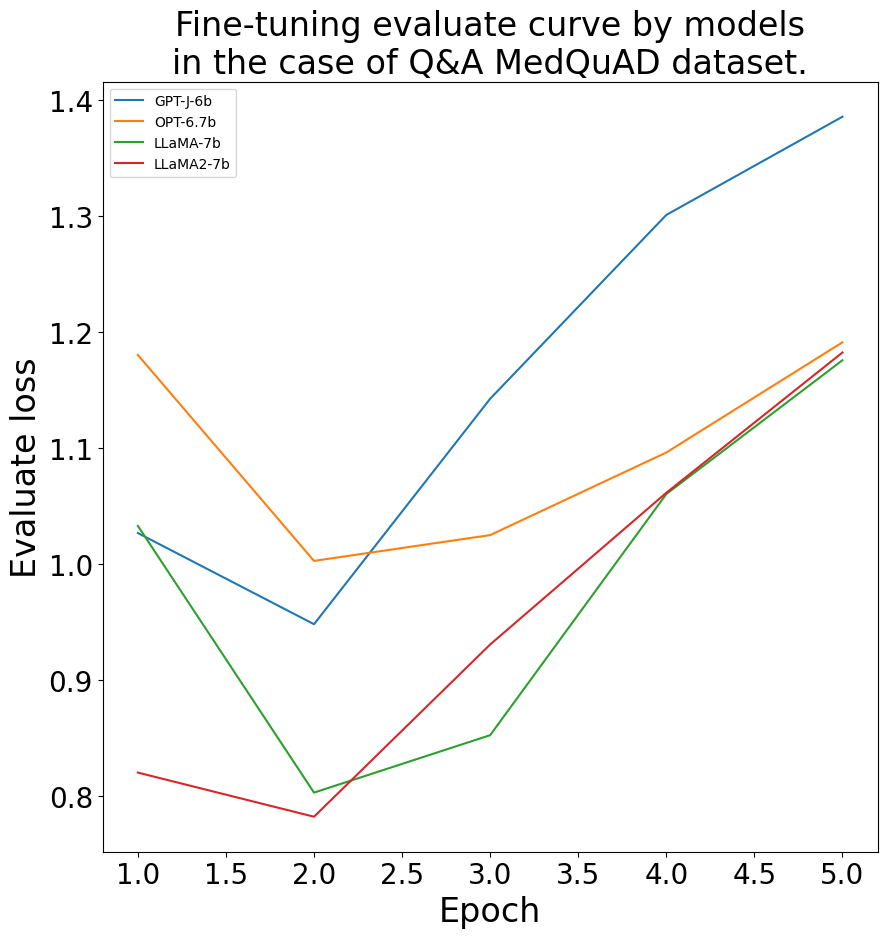

In [53]:
train_models = pd.DataFrame({"GPT-J-6b" : val_gptj[["eval_loss"]].dropna()["eval_loss"].values,
                             "OPT-6.7b" : val_opt[["eval_loss"]].dropna()["eval_loss"].values,
                             "LLaMA-7b" : val_llama[["eval_loss"]].dropna()["eval_loss"].values,
                             "LLaMA2-7b" : val_llama2[["eval_loss"]].dropna()["eval_loss"].values})
train_models["indexes"] = [1,2,3,4,5]
train_models = train_models.set_index("indexes")

# plt.figure()
train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Evaluate loss', fontsize=24)
plt.title("Fine-tuning evaluate curve by models\nin the case of Q&A MedQuAD dataset.", fontsize=24)
plt.savefig('../images/fn_evaluate_curve_medquad.png')
plt.show()

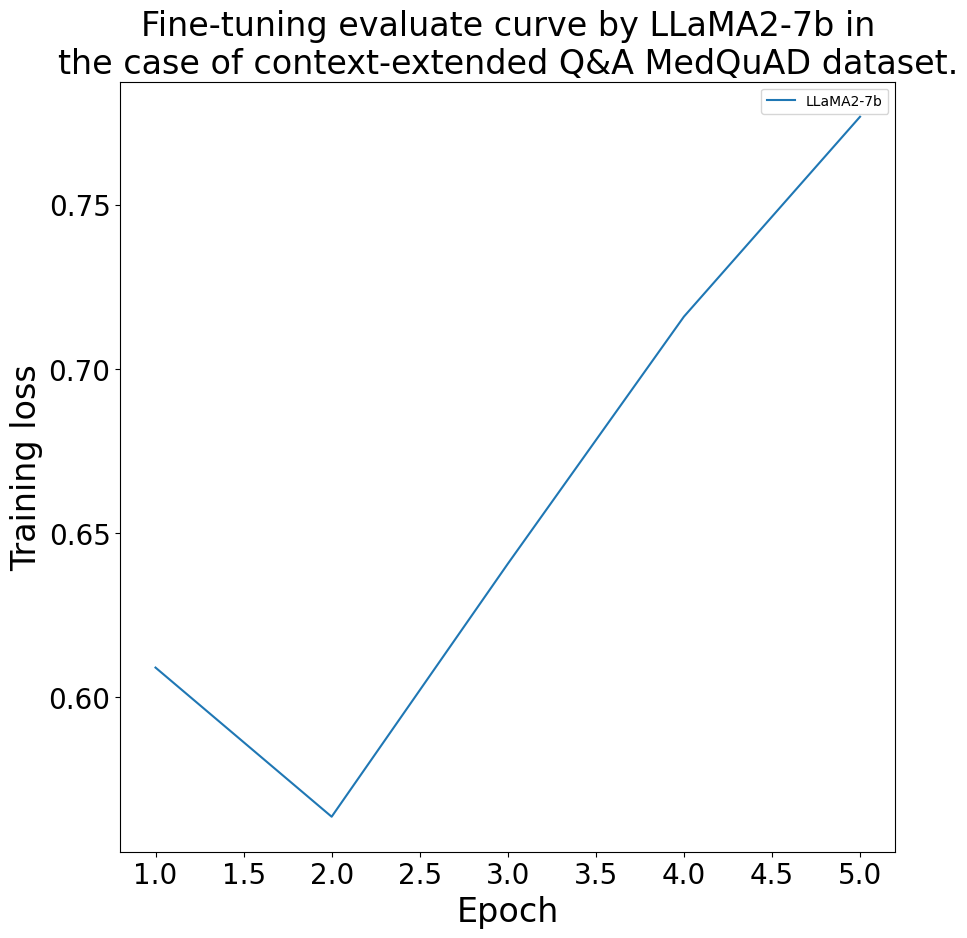

In [54]:
train_models = pd.DataFrame({"LLaMA2-7b" : val_llama2_c[["eval_loss"]].dropna()["eval_loss"].values})
train_models["indexes"] = [1,2,3,4,5]
train_models = train_models.set_index("indexes")

train_models.plot(figsize=(10, 10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Training loss', fontsize=24)
plt.title("Fine-tuning evaluate curve by LLaMA2-7b in\nthe case of context-extended Q&A MedQuAD dataset.", fontsize=24)
plt.savefig('../images/fn_evaluate_curve_context_extended_medquad.png')
plt.show()